In [1]:
from tqdm.notebook import tqdm as tqm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
from math import pi
from scipy import fft
import pyfftw as fftw
# Opciones de matplotlib
rc=plt.rcParams
rc['figure.figsize']=[15,5]

# Para mostrar todas las columnas cuando se imprime un df
pd.set_option('display.max_columns', None)

In [2]:
div=100
n_ventana=1024
freq_sampleo=48_000

T=n_ventana/freq_sampleo
t=np.linspace(0,T,num=div)
s1=np.sin(2*np.pi/T*t)

fig=px.line(x=t,y=s1,markers=True)

fig.update_layout(
    title='s1',xaxis_title='t', yaxis_title='s(t)',
    height=500, width=900, template='plotly_dark'
)

fig.show()


In [3]:
# Armamos el arreglo de frecuencias
f_NS=freq_sampleo//2
freq_array=np.zeros(len(s1))
f1=freq_sampleo/n_ventana
for i in range(1,len(freq_array)//2):
    freq_array[i]=f1*i 
    freq_array[len(freq_array)-i]=-freq_array[i]

In [4]:
s_hat=np.abs(fft.fft(s1))
freq_array_string=[str(fi) for fi in freq_array]
fig=px.bar(x=freq_array_string,y=s_hat)

fig.update_layout(
    title='Transformada de Fourier',xaxis_title='f:frecuencia', yaxis_title='|s_hat(f)|',
    height=500, width=900, template='plotly_dark'
)

fig.show()

# Creando señales

Creamos señales y su salida a los respectivos micrófonos de acuerdo a los parámetros

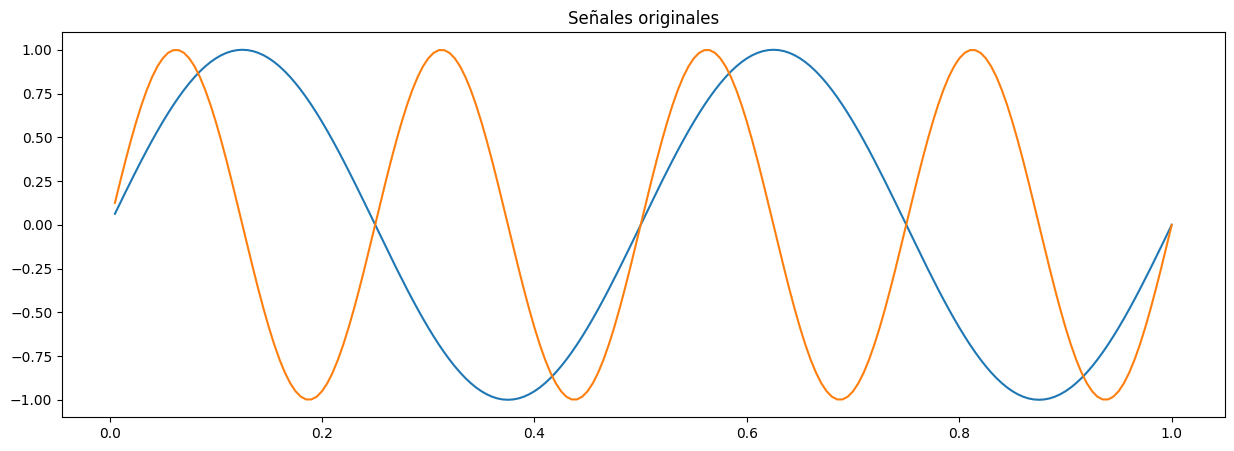

In [5]:
DOAS=[-30,40] # DOA en grados
d_im=20 # distancia inter-micrófono, arreglo lineal
K=200 # Tamaño de señal en sampleo, también es la frecuencia de sampleo
n_ventana=K
freq_sampleo=K

f_NS=freq_sampleo//2
freq_array=np.zeros(K)
f1=freq_sampleo/n_ventana
for i in range(1,len(freq_array)//2):
    freq_array[i]=f1*i 
    freq_array[len(freq_array)-i]=-freq_array[i]
freq_array[K//2]=f_NS
freq_array_string=[str(fi) for fi in freq_array]

freqs=[2,4] # frecuencia de las señales
c=343 # Velocidad del sonido
t=np.linspace(1,K,num=K)/K

N_mic=3
n_ruidoso=2 

s1=np.sin(2*np.pi*freqs[0]*t)
s2=np.sin(2*np.pi*freqs[1]*t)

plt.title('Señales originales')
plt.plot(t,s1,label='Señal 1')
plt.plot(t,s2,label='Señal 2')
plt.show()

In [211]:
s_1=lambda x: np.sin(2*pi*freqs[0]*x)
s_1(t)==s1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

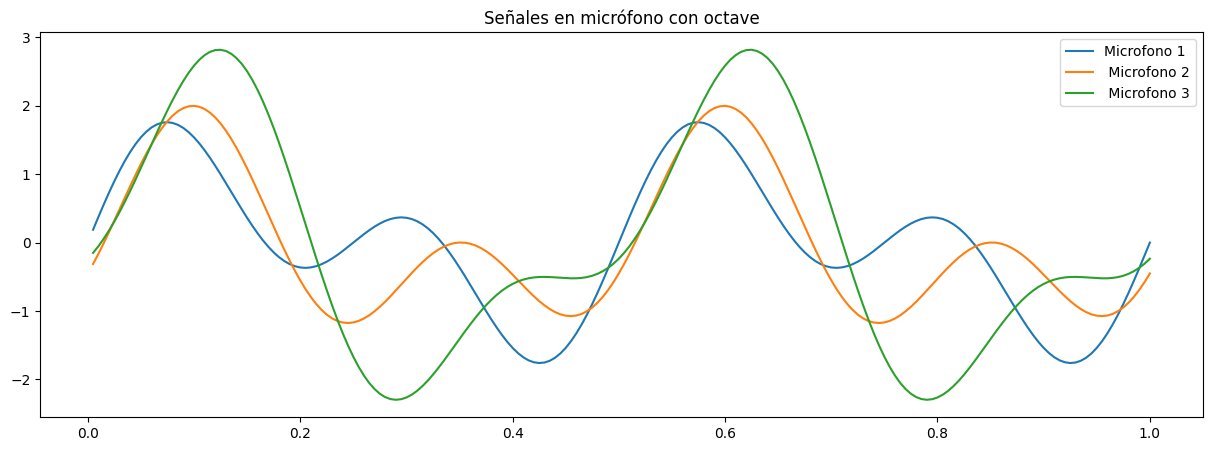

In [6]:
k=np.array([-2*pi*d_im/c*np.sin(di*pi/180) for di in DOAS]) # el exponente de cada exp por el que hay que multiplicar la transformada con la frecuencia para que dé el tensor S
# np.exp(-2*pi*1j)

x=s1+s2
y=fft.ifft(fft.fft(s1)*np.exp(k[0]*freq_array*1j)).real+fft.ifft(fft.fft(s2)*np.exp(k[1]*freq_array*1j)).real
z=fft.ifft(fft.fft(s1)*2*np.exp(k[0]*freq_array*1j)).real+fft.ifft(fft.fft(s2)*np.exp(k[1]*2*freq_array*1j)).real
plt.title('Señales en micrófono con octave')
plt.plot(t,x,label='Microfono 1')
plt.plot(t,y,label=' Microfono 2')
plt.plot(t,z,label=' Microfono 3')
plt.legend()
plt.show()

Hacemos el mismo cálculo usando los tensores y para comprobar lo checamos contra la gráfica anterior

In [208]:
def a_theta_f(theta,f,N_mic=N_mic,d_im=d_im,c=c):
    
    k=-2*pi*d_im/c*np.sin(theta*pi/180)
    a=[np.exp(k*f*ni*1j) for ni in range(N_mic)]
    return np.array(a)

def A_f(thetas,f,N_mic=N_mic,d_im=d_im,c=c):
    A=np.zeros(shape=(N_mic,len(thetas)))+0j
    for i in range(len(thetas)):
        A[:,i]=a_theta_f(thetas[i],f,d_im=d_im)
    
    return A


def A_completa(thetas,freqs,N_mic=N_mic,d_im=d_im,c=c):
    A=np.zeros(shape=(len(freqs),N_mic,len(thetas)))+0j
    for i in range(len(freqs)):
        A[i,:,:]=A_f(thetas,freqs[i],d_im=d_im)
    
    return A


In [206]:
s_t=[s1,s2]
s_vec=s_t[0]
for i in range(1,len(s_t)):
    s_vec=np.c_[s_vec,s_t[i]]
# s_vec=np.c_[s_t]
s_vec=np.c_[s1,s2]
s_vec.shape

(200, 2)

In [8]:
A=A_completa(DOAS,freqs=freq_array)
s_vec=np.c_[s1,s2]
s_hat_vec=fft.fft(s_vec,axis=0)
x_mics=np.zeros((N_mic,len(freq_array)))+0j
for i in range(A.shape[0]):
    x_mics[:,i]=A[i,:,:]@s_hat_vec[i,:]
x_mics=fft.ifft(x_mics,axis=1).real

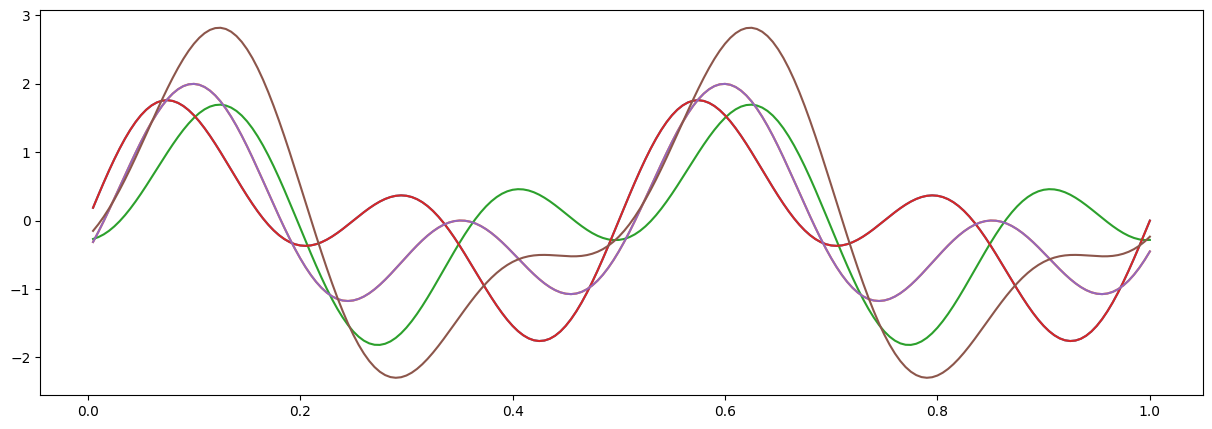

In [9]:
plt.plot(t,x_mics[0])
plt.plot(t,x_mics[1])
plt.plot(t,x_mics[2])

plt.plot(t,x)
plt.plot(t,y)
plt.plot(t,z)
plt.show()

como las gráficas se ven iguales sabemos que es un buen método para obtener lo que se observa en el micrófono

Todo en una función

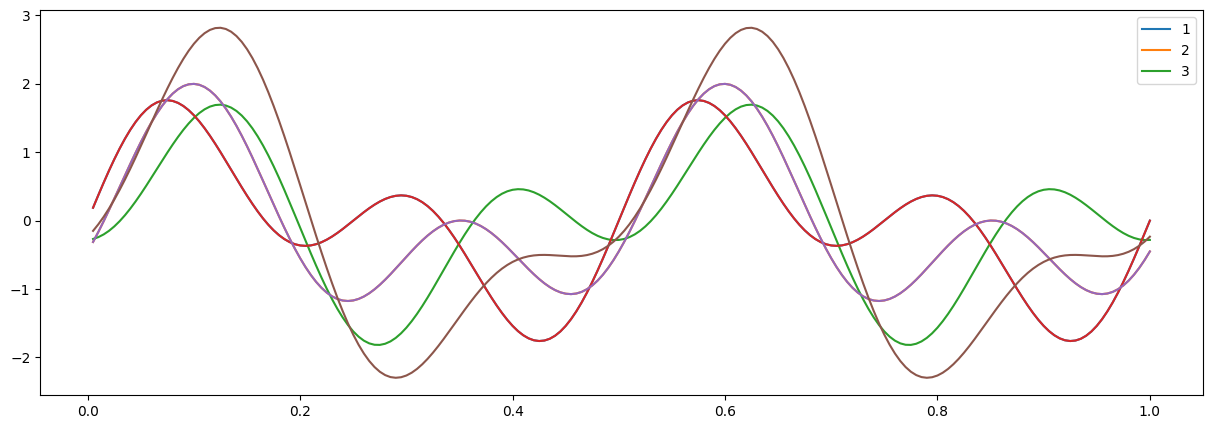

array([[ 1.88123753e-01,  3.74023121e-01,  5.55505867e-01,
         7.30443561e-01,  8.96802247e-01,  1.05267166e+00,
         1.19629253e+00,  1.32608160e+00,  1.44065385e+00,
         1.53884177e+00,  1.61971124e+00,  1.68257383e+00,
         1.72699536e+00,  1.75280049e+00,  1.76007351e+00,
         1.74915498e+00,  1.72063461e+00,  1.67534030e+00,
         1.61432359e+00,  1.53884177e+00,  1.45033684e+00,
         1.35041180e+00,  1.24080459e+00,  1.12335996e+00,
         1.00000000e+00,  8.72693495e-01,  7.43424814e-01,
         6.14162698e-01,  4.86829487e-01,  3.63271264e-01,
         2.45229380e-01,  1.34313810e-01,  3.19787545e-02,
        -6.04991270e-02, -1.42039522e-01, -2.11774008e-01,
        -2.69058101e-01, -3.13479622e-01, -3.44863261e-01,
        -3.63271264e-01, -3.69000257e-01, -3.62574251e-01,
        -3.44733951e-01, -3.16422553e-01, -2.78768258e-01,
        -2.33063787e-01, -1.80743238e-01, -1.23356654e-01,
        -6.25427140e-02,  3.55271368e-17,  6.25427140e-0

In [256]:
def gen_señales_mic(DOAS,señales,d_im,N_mic,n_ventana=1024,freq_sampleo=48_000):
    '''
    DOAS: Los ángulos en grados de las señales de entrada 
    d_im: distancia inter-micrófono
    n_ventana: el tamaño de la muestra 
    señales: funciones o arreglos que se le aplican a los datos 
    '''
    
    # Se obtienen las frecuencias de la transformada rápida
    f_NS=freq_sampleo//2
    freq_array=np.zeros(K)
    f1=freq_sampleo/n_ventana
    for i in range(1,len(freq_array)//2):
        freq_array[i]=f1*i 
        freq_array[len(freq_array)-i]=-freq_array[i]
    freq_array[K//2]=f_NS
    # freq_array_string=[str(fi) for fi in freq_array]
    t=np.linspace(1,n_ventana,num=n_ventana)*(n_ventana/freq_sampleo)/n_ventana # Para que esté en un intervalo de un segundo 
    s_t=[s(t) for s in señales]
    # return s_t

    A=A_completa(DOAS,freqs=freq_array,d_im=d_im)

    s_vec=s_t[0]
    for i in range(1,len(s_t)):
        s_vec=np.c_[s_vec,s_t[i]]

    s_hat_vec=fft.fft(s_vec,axis=0)

    x_mics=np.zeros((N_mic,len(freq_array)))+0j
    for i in range(A.shape[0]):
        x_mics[:,i]=A[i,:,:]@s_hat_vec[i,:]
    x_mics=fft.ifft(x_mics,axis=1).real
    return x_mics

señales=[lambda x: np.sin(2*pi*freqs[0]*x),lambda x: np.sin(2*pi*freqs[1]*x)]

x_mics=gen_señales_mic(DOAS,señales,d_im,N_mic,K,K)
plt.plot(t,x_mics[0],label='1')
plt.plot(t,x_mics[1],label='2')
plt.plot(t,x_mics[2],label='3')

plt.plot(t,x)
plt.plot(t,y)
plt.plot(t,z)
plt.legend()
plt.show()
x_mics

In [250]:
K

200

# MUSIC Ejemplo de clase

Ya con las señales de micrófono en general, se puede
- Generar señales más complicadas que tengan más frecuencias
- Poner los parámetros del problema de JACK
- Dividir en ventanas para hacer wola y ver cómo se le va a hacer al problema en general

Pero antes de eso primero hay que tratar esto como si fuera una sóla ventana e ir haciendo el análisis de los estimadores de la función de covarianza

In [189]:
angles=np.arange(-90,90,0.1) # Los ángulos para buscar ortogonalidad


Se tendría que buscar para todas las frecuencias, pero aquí ya sabemos que están en [2,4] así que ahí vamos a buscar

In [190]:
fig=px.bar(x=freq_array_string,y=np.abs(s_hat_vec)[:,0])
fig.update_layout(
    title='Transformada para Señal 1',xaxis_title='f', yaxis_title='s1_hat(f)',
    height=500, width=900, template='plotly_dark',
)

fig.add_bar(x=freq_array_string,y=np.abs(s_hat_vec)[:,1],name='señal 2')
fig.show()



In [193]:
this_ws=[2,4,6,8]
# Se seleccionan las componentes de las señales en el espacio de frecuencia que buscamos 
X=fft.fft(x_mics,axis=1)
music_spectrum=np.zeros(shape=(len(this_ws),len(angles)))


In [194]:
for i,wi in enumerate(this_ws):
    this_X=X[:,wi] # Esta es la que tiene que ser calculada usando ventanas anteriores. Cuando dividas en varias ventanas de Hann, se debería de ver una diferencia en la estimación
    R=this_X.reshape(-1,1)*this_X.conj().T

    D,Q=np.linalg.eig(R)
    I=np.argsort(D.real)[::-1]
    D=D[I]
    Q=Q[:,I]


    Qs=Q[:,1:n_ruidoso]
    Qn=Q[:,n_ruidoso:]

    A_angles=A_completa(thetas=angles,freqs=[wi])

    for k in range(len(angles)):
        music_spectrum[i,k]=np.abs(1/(A_angles[0,:,k].conj().T@(Qn*Qn.conj().T@A_angles[0,:,k])))
  

In [195]:
px.line(x=angles,y=music_spectrum[1,:])

traces=[go.Scatter(x=angles,y=music_spectrum[i,:],mode='lines',name=f'Frecuencia {i}') for i in range(len(this_ws))]
fig=go.Figure()
[fig.add_trace(trace) for trace in traces]
fig.update_layout(
    title='Music',xaxis_title='x', yaxis_title='F(x)',
    height=500, width=900, template='plotly_dark'
)
fig.show()

![cov](cov.png)

Ver si se puede agarrar el perfil de sonido, si no hacerlo escribiendo con Jack 